
### Objective
The objective of this project is to evaluate the production predictability in the following economic sector:

Industrial Production: Manufacturing: Non-Durable Goods: Sugar and Confectionery Product (NAICS = 3113) (IPG3113N)	


### Data 
Data on the monthly candy production was retrieved from the Federal Bank of St.Louis ECONOMIC RESEARCH:

https://fred.stlouisfed.org/series/IPG3113N

The data is also available on Kaggle:

https://www.kaggle.com/rtatman/us-candy-production-by-month


### Modeling and Evaluation
The evaluation models that will be used are:
* Autoregressive Integrated Moving Average (ARIMA) model
* Seasonal Autoregressive Integrated Moving Average (SARIMAX) model

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data

In [2]:
original_production_df = pd.read_csv('../input/us-candy-production-by-month/candy_production.csv')

In [3]:
# make a copy to retain the data integrity of the original
df=original_production_df.copy()

In [4]:
# a brief glance at the data
df

,observation_date,IPG3113N
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100
...,...,...
543,2017-04-01,107.4288
544,2017-05-01,101.9209
545,2017-06-01,104.2022
546,2017-07-01,102.5861


In [5]:
# rename column 'IPG3113N' as candy_production
df.rename(columns={'IPG3113N':'candy_production'}, inplace=True)

In [6]:
df.head()

,observation_date,candy_production
0,1972-01-01,85.6945
1,1972-02-01,71.8200
2,1972-03-01,66.0229
3,1972-04-01,64.5645
4,1972-05-01,65.0100


### Data Preprocessing


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   observation_date  548 non-null    object 
 1   candy_production  548 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.7+ KB


In [8]:
df['observation_date'] = pd.to_datetime(df['observation_date'])

In [9]:
df.set_index('observation_date',inplace=True)

In [10]:
# check for missing data
df.isnull().sum()

candy_production    0
dtype: int64

### Data Visualization

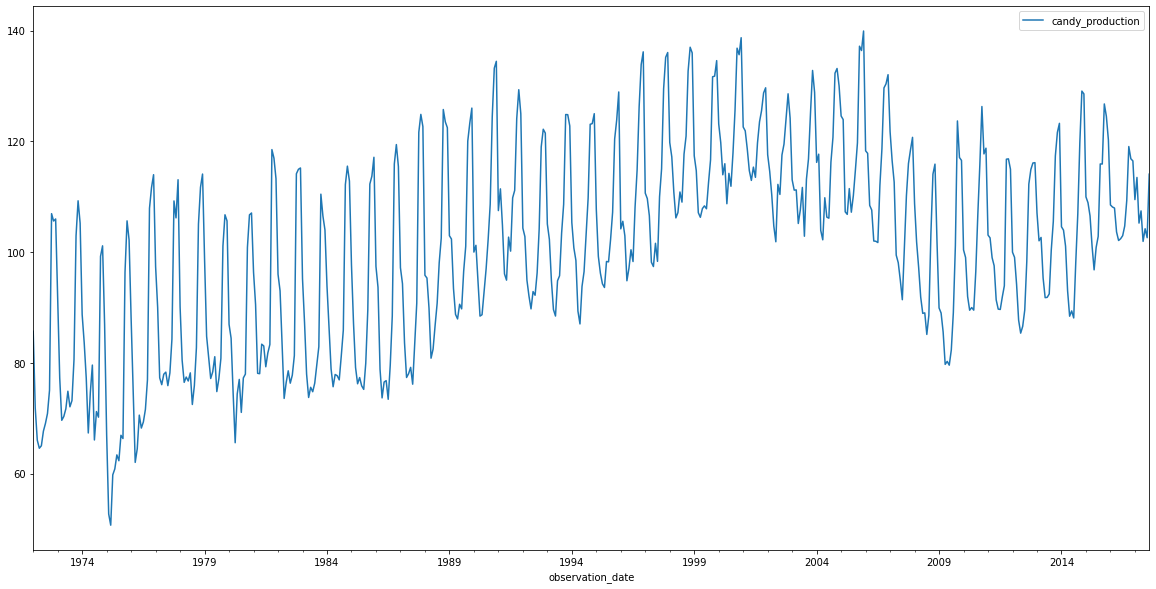

In [11]:
df.plot(figsize=(20,10));

In [12]:
timeseries = df['candy_production']

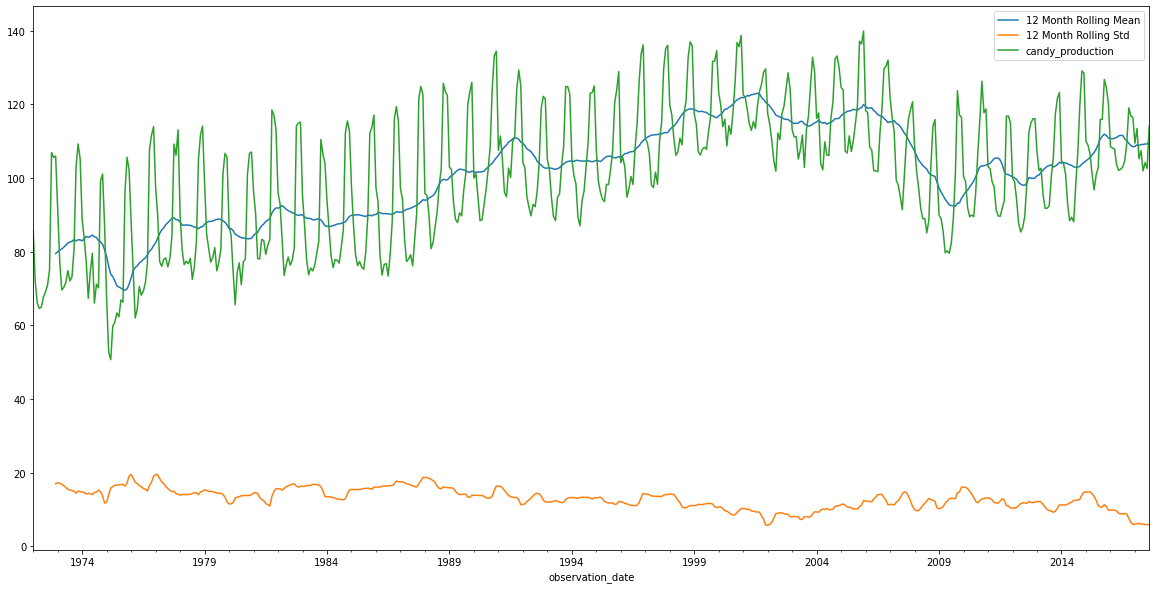

In [13]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot(figsize=(20,10))
plt.legend();

### Decomposition

ETS (Error, Trend, Seasonality) Decomposition model gives another view of the data.

<Figure size 432x288 with 0 Axes>

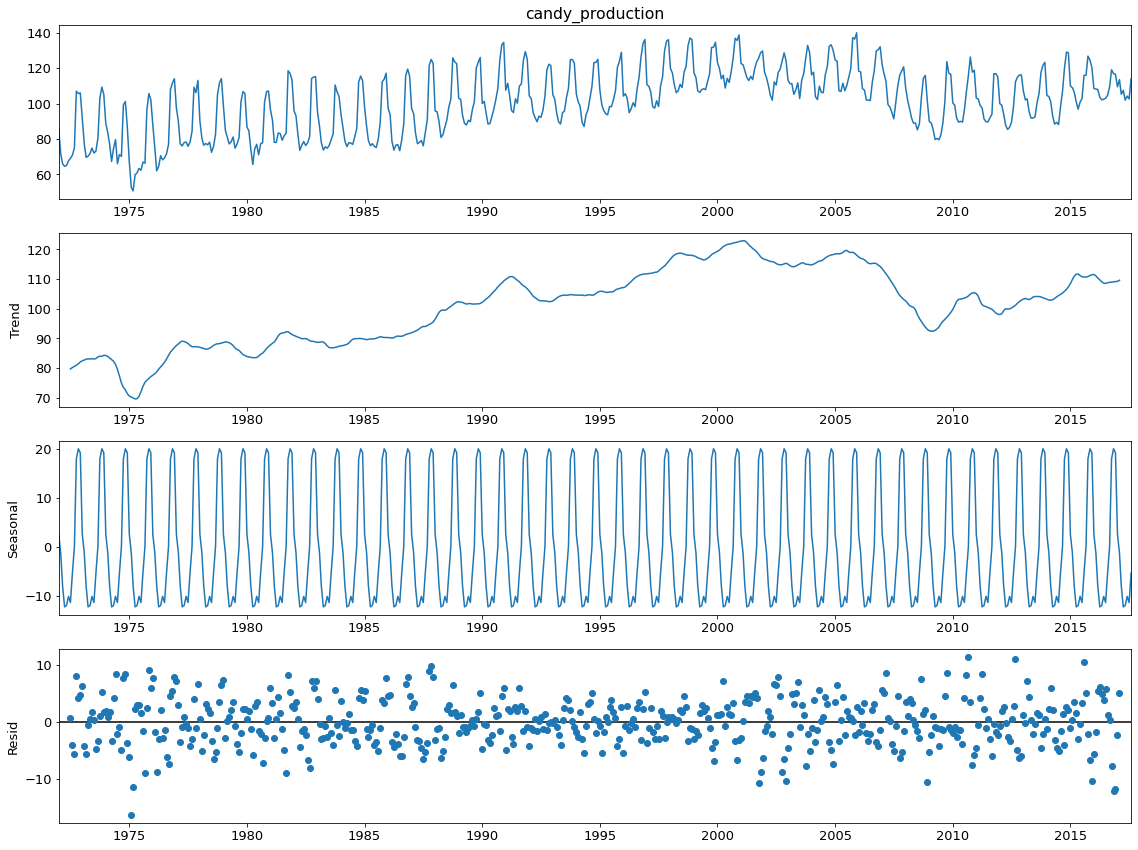

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['candy_production'], period=12)  
fig = plt.figure()  
plt.rc('figure',figsize=(16,12))
plt.rc('font',size=13)
fig = decomposition.plot();

### Test stationarity of time series data

In statistics and econometrics, the augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

To accept the Null Hypothesis **H0** (that the time series has a unit root, indicating it is non-stationary) or reject **H0** and go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

The p-value will be the factor to decide the with Null Hypothesis or the Alternative Hypothesis in terms of stationarity:

* A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

* A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.


In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
result = adfuller(df['candy_production'])

In [17]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.8870498112252712
p-value : 0.3381775973004335
#Lags Used : 14
Number of Observations Used : 533
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [18]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

## Differencing

Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model. The first differencing value is the difference between the current time period and the previous time period. You continue to take the second difference, third difference, and so on until your data is stationary.

### First Difference 

The first difference of a time series is the series of changes from one period to the next. If Yt denotes the value of the time series Y at period t, then the first difference of Y at period t is equal to Yt-Yt-1.

In [19]:
df['First Difference'] = df['candy_production'] - df['candy_production'].shift(1)

In [20]:
adf_check(df['First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.119511504715768
p-value : 8.925584203569505e-08
#Lags Used : 13
Number of Observations Used : 533
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


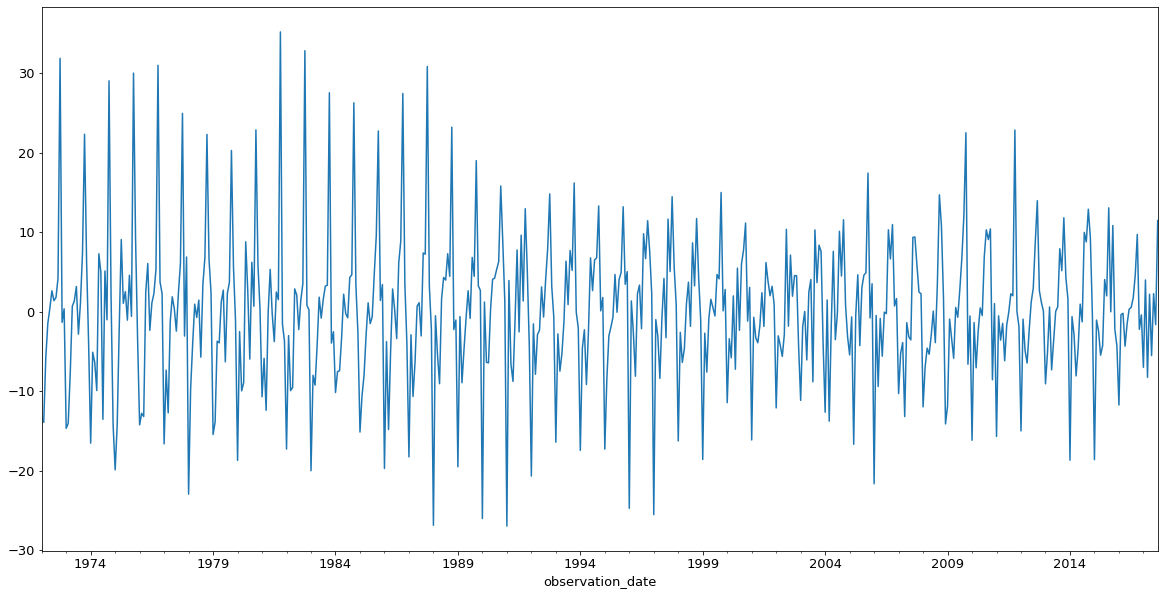

In [21]:
df['First Difference'].plot(figsize=(20,10));

### Second Difference  

In [22]:
# Sometimes it would be necessary to do a second difference 
# This is just for show, we didn't need to do a second difference in our case
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)

In [23]:
adf_check(df['Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.679252049841658
p-value : 1.5193804285397875e-11
#Lags Used : 19
Number of Observations Used : 526
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


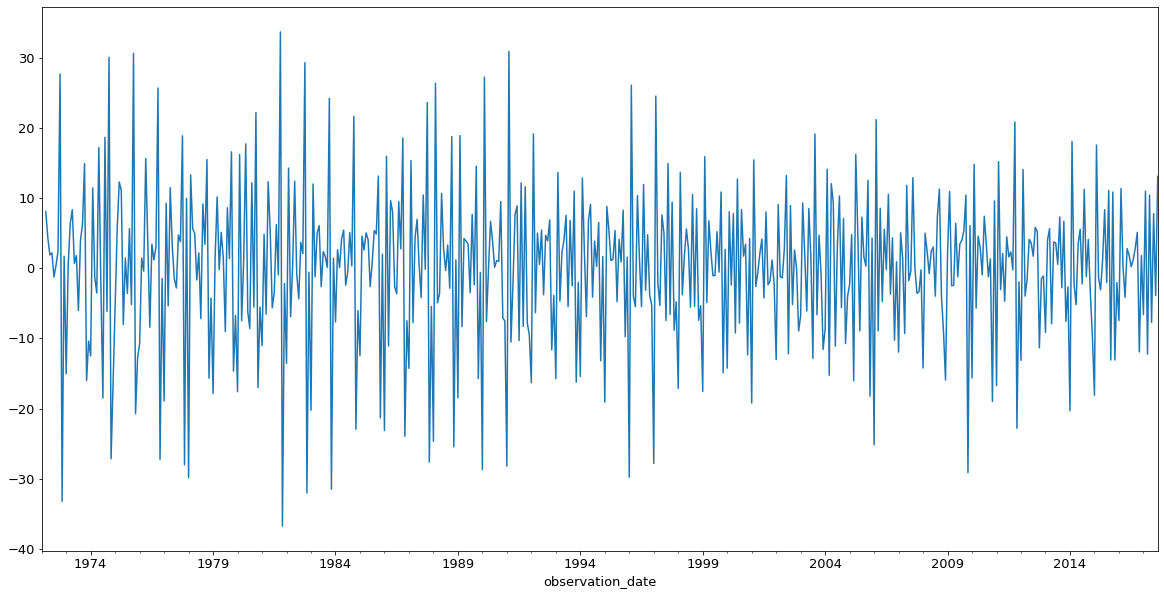

In [24]:
df['Second Difference'].plot(figsize=(20,10));

### Seasonal Difference 

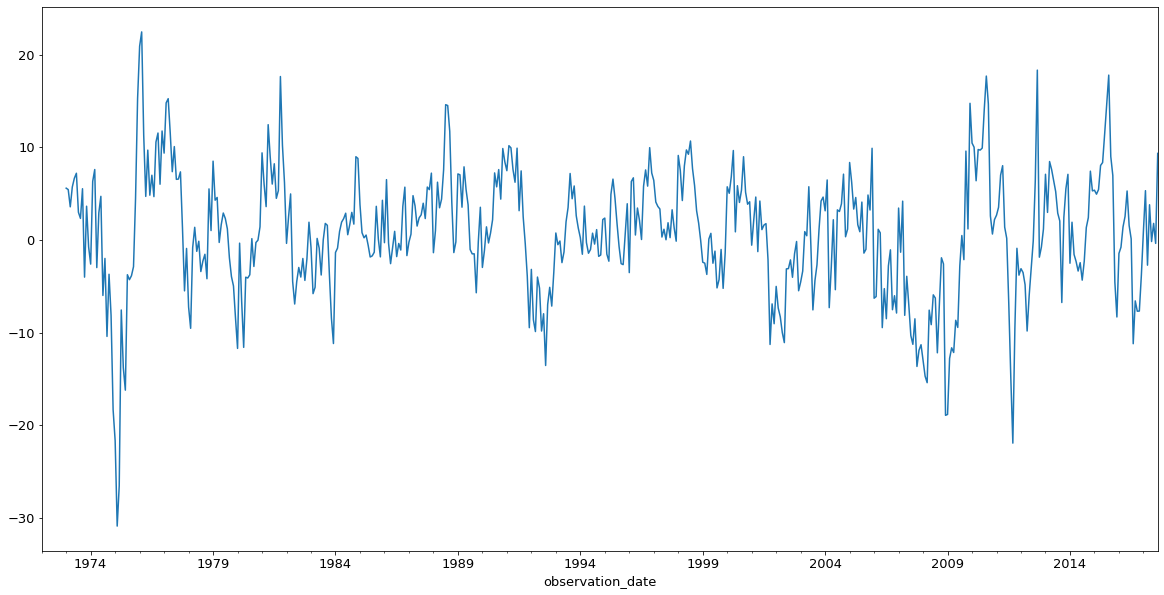

In [25]:
df['Seasonal Difference'] = df['candy_production'] - df['candy_production'].shift(12)
df['Seasonal Difference'].plot(figsize=(20,10));

In [26]:
# Seasonal Difference by itself was not enough!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.989819790366841
p-value : 2.3246095576919298e-05
#Lags Used : 19
Number of Observations Used : 516
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


### Seasonal First Difference 

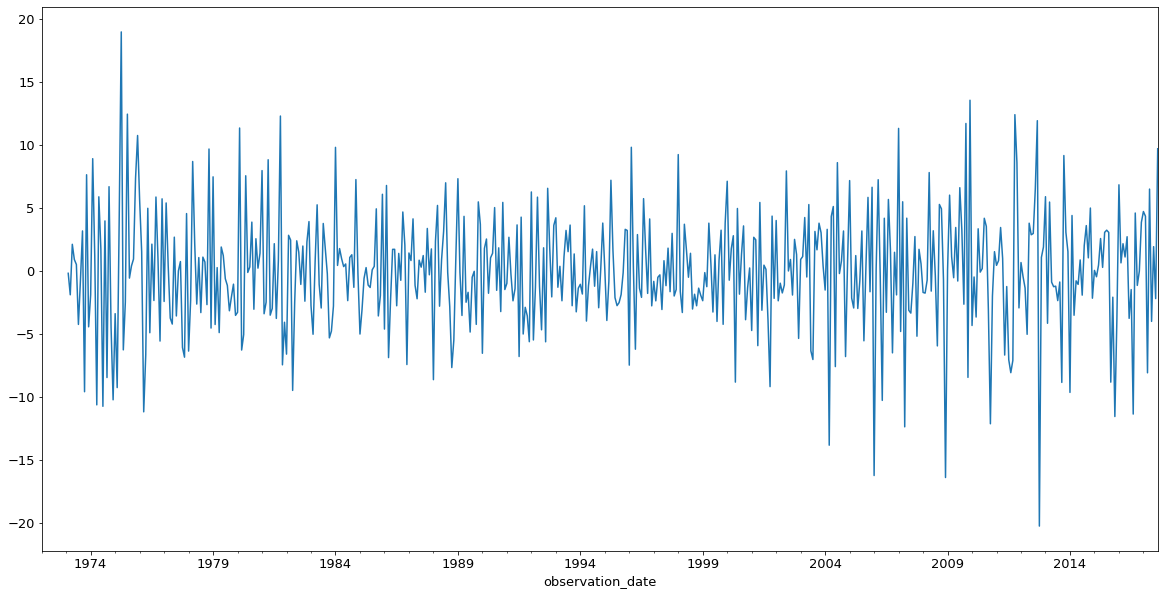

In [27]:
# You can also do seasonal first difference
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)
df['Seasonal First Difference'].plot(figsize=(20,10));

In [28]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.899059433258932
p-value : 4.233176223636201e-12
#Lags Used : 18
Number of Observations Used : 516
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


## Autocorrelation and Partial Autocorrelation Plots


### Autocorrelation 

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It measures the relationship between a variable's current value and its past value.

The interpretation of Autocorrelation is how it relates to the ARIMA model and understand which of the, AR or MA, components does the ARIMA model use or both, as well as, how many lags to use. 

In general one would use either AR or MA of the model, using both is less common.

* If the autocorrelation plot shows positive autocorrelation at the first lag (lag-1), this suggests using the AR terms in relation to the lag

* If the autocorrelation plot shows negative autocorrelation at the first lag, this suggests using MA terms.

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

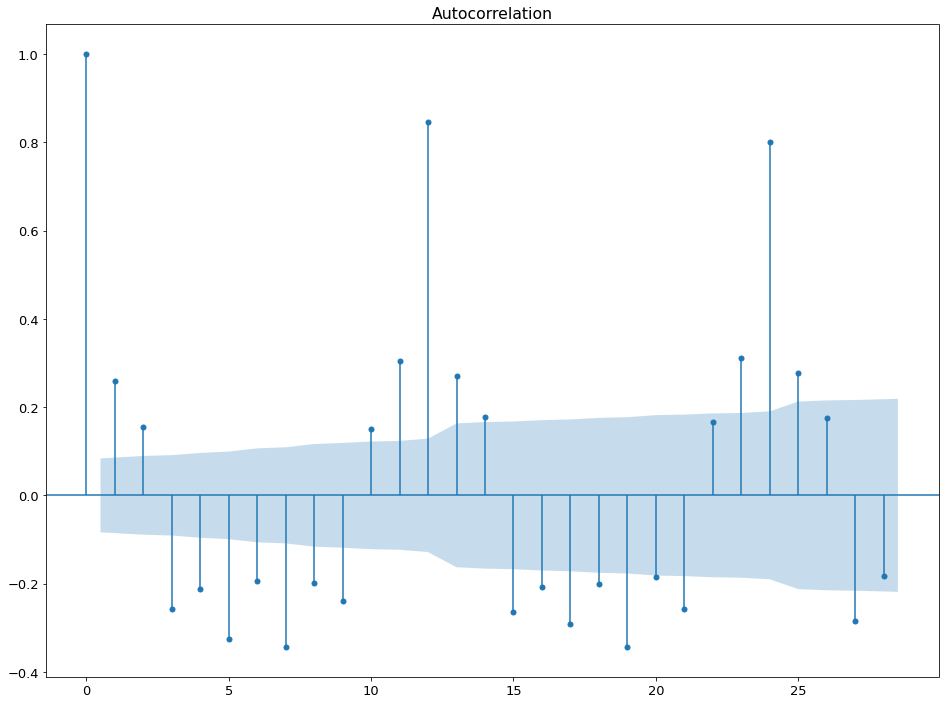

In [30]:
# Duplicate plots
fig_first = plot_acf(df["First Difference"].dropna())

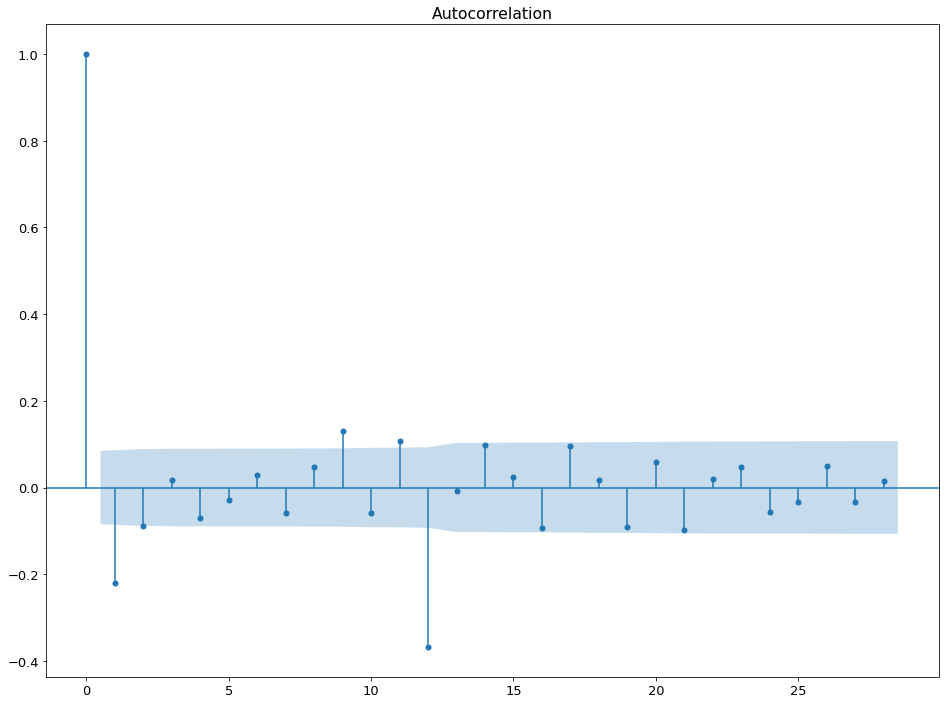

In [31]:

fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna())

In [32]:
#from pandas.plotting import autocorrelation_plot
#autocorrelation_plot(df['Seasonal First Difference'].dropna())


### Partial Autocorrelation

In general, a partial correlation is a conditional correlation. It is the correlation between two variables under the 
assumption that we know and take into account the values of some other set of variables. For instance, consider a regression 
context in which y is the response variable and x1,x2, and x3 are predictor variables. The partial correlation between 
y and x3 is the correlation between the variables determined taking into account how both y and x3 are related to x1 and x2.

More formally, we can define the partial correlation just described as:

$ 
\huge\frac{\text{Covariance}(y, x_3|x_1, x_2)}{\sqrt{\text{Variance}(y|x_1, x_2)\text{Variance}(x_3| x_1, x_2)}}
$


this relationship is plotted as:

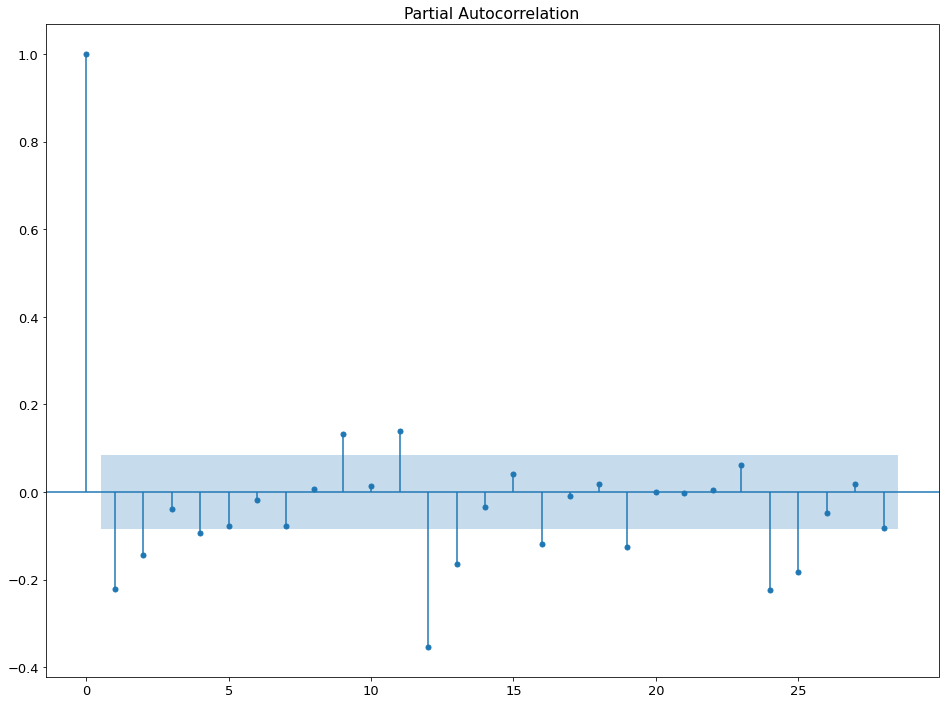

In [33]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

### Autocorrelation and Partial Autocorrelation: Identifying Model to Employ

* Identification of an AR model is often observed with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often observed with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

### Autocorrelation Interpretation
 
* A sharp drop after lag "k" suggests an AR-k model should be used. 
* A gradual decline, suggests an MA model should be employed.

### Final ACF and PACF Visualization Plots


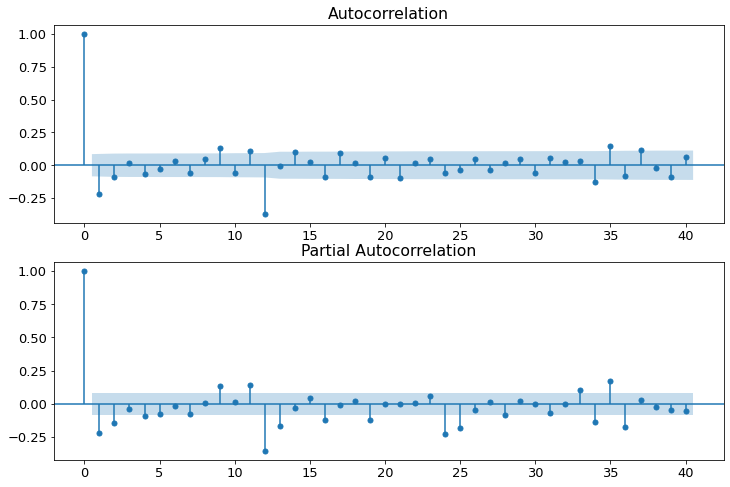

In [34]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## ARIMA modeling 

In [35]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

### p,d,q parameters

* p: The number of lag observations included in the model.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

In [36]:
df.describe()

,candy_production,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference
count,548.000000,547.000000,546.000000,536.000000,535.000000
mean,100.662524,0.051859,0.046428,0.682547,0.007025
std,18.052931,9.029494,10.976471,6.750198,4.709556
min,50.668900,-26.959500,-36.740300,-30.913400,-20.217500
25%,87.862475,-4.017600,-5.556500,-2.962375,-2.726850
50%,102.278550,0.038200,1.012100,0.904000,0.032100
75%,114.691900,4.218350,6.073250,5.182325,2.910100
max,139.915300,35.202700,33.675200,22.491400,19.001500


In [37]:
df.index = pd.DatetimeIndex(df.index, freq='MS')

In [38]:

# modelling with seasonal data
model = sm.tsa.statespace.SARIMAX(df['candy_production'],
                                  order=(0,1,0),
                                  freq = 'MS',
                                  seasonal_order=(1,1,1,12))


results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                     candy_production   No. Observations:                  548
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -1498.178
Date:                              Wed, 26 May 2021   AIC                           3002.356
Time:                                      19:59:14   BIC                           3015.202
Sample:                                  01-01-1972   HQIC                          3007.382
                                       - 08-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1668      0.053      3.145      0.002       0.063       0.271
ma.S.L12      -0.80

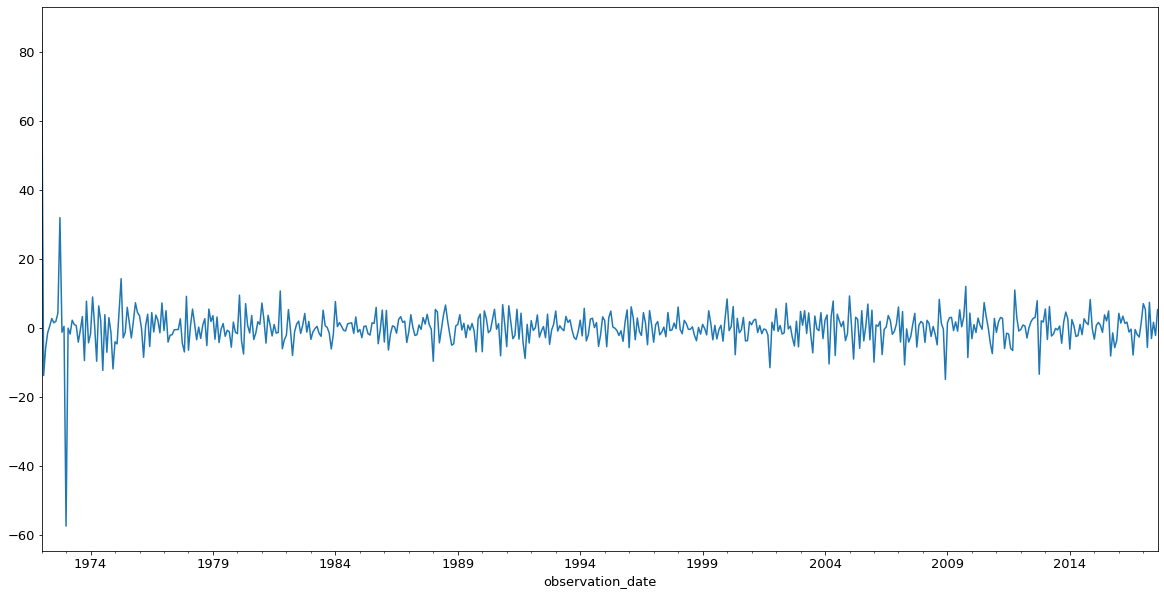

In [39]:
results.resid.plot(figsize=(20,10));

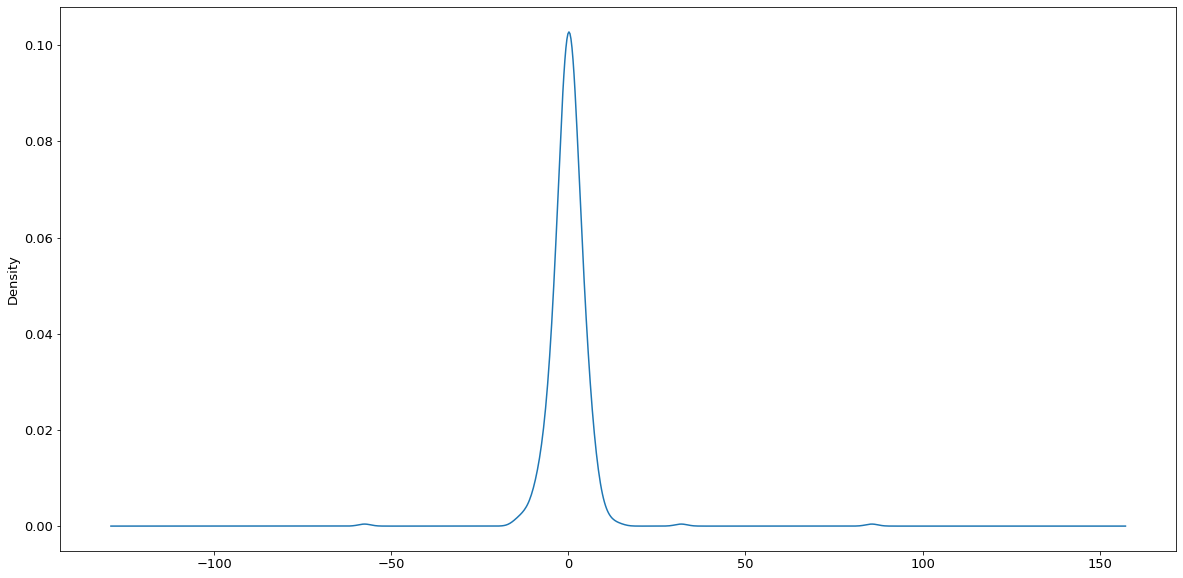

In [40]:
results.resid.plot(kind='kde',figsize=(20,10));

### Projection of Future Values 

We can get an idea of how well our model performs by just predicting for values that we already have:

In [41]:
df

,candy_production,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference
observation_date,,,,,
1972-01-01,85.6945,NaN,NaN,NaN,NaN
1972-02-01,71.8200,-13.8745,NaN,NaN,NaN
1972-03-01,66.0229,-5.7971,8.0774,NaN,NaN
1972-04-01,64.5645,-1.4584,4.3387,NaN,NaN
1972-05-01,65.0100,0.4455,1.9039,NaN,NaN
...,...,...,...,...,...
2017-04-01,107.4288,2.2043,10.4459,3.8109,6.5281
2017-05-01,101.9209,-5.5079,-7.7122,-0.1607,-3.9716
2017-06-01,104.2022,2.2813,7.7892,1.7978,1.9585


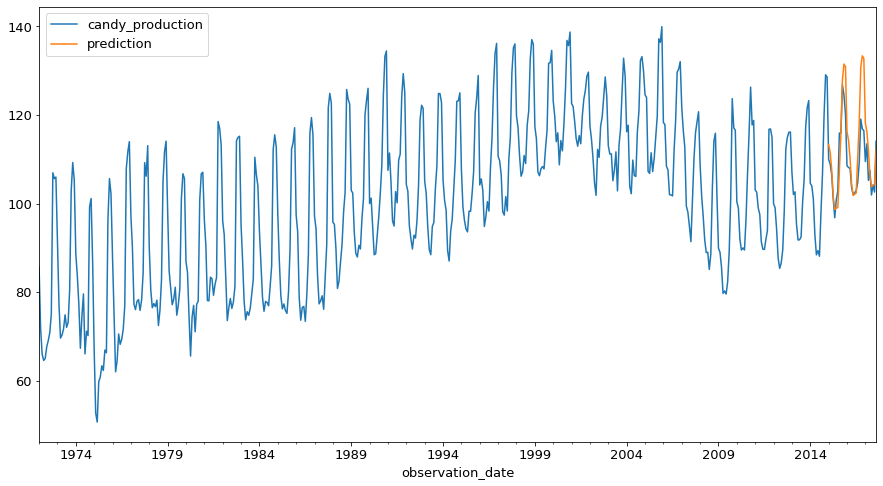

In [42]:
df['prediction'] = results.predict(start = '2015-01-01', end='2017-08-01', dynamic= True)  
df[['candy_production','prediction']].plot(figsize=(15,8));

References: PierienData, Wikipedia